# Generating Shakespearean Text Using a Character RNN

In a famous [2015 blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) titled “The Unreasonable Effectiveness of Recurrent Neural Networks,” Andrej Karpathy showed how to train an RNN to predict the next character in a sentence

This **Char-RNN** can then be used to generate novel text, one character at a time

## Creating the Training Dataset

First, let’s download all of Shakespeare’s work, using Keras’s handy get_file() function and downloading the data from Andrej Karpathy’ [Char-RNN project](https://github.com/karpathy/char-rnn):

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

In [60]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [61]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



Next, we must encode every character as an integer. One option is to create a custom preprocessing layer, as we did in Chapter 13

But in this case, it will be simpler to use Keras’ Tokenizer class. First we need to fit a **tokenizer** to the text: **it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters** (it does not start at 0, so we can use that value for masking, as we will see later in this chapter):

In [62]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

We set **char_level=True** to get **character-level encoding rather than the default word-level encoding**. Note that this **tokenizer converts the text to lowercase by default** (but you can set lower=False if you do not want that)

Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [63]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [64]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [65]:
max_id = len(tokenizer.word_index) # number of distinct characters
max_id

39

In [66]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [67]:
import numpy as np
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Before we continue, we need to split the dataset into a training set, a validation set, and a test set. We **can’t just shuffle all the characters in the text,** so how do you split a sequential dataset?

## How to Split a Sequential Dataset

For example, we can take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set

It would also be a good idea to **leave a gap between these sets** to **avoid** the risk of a **paragraph overlapping** over two sets

When dealing with time series, you would in **general split across time,:** for example, you might take the years **2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.** However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on

So, it is often safer to split across time—but this implicitly **assumes that the patterns the RNN can learn in the past** (in the training set) **will still exist in the future.** In other words, we assume that the time series is **stationary**

For many time series this assumption is reasonable **(e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day),** but f**or many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them)**

To **make sure** the time series is indeed sufficiently **stationary,** you can **plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough,** and you might be **better off training the model on a shorter time span.**

Now back to Shakespeare! Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [68]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## Chopping the Sequential Dataset into Multiple Windows

The training set now consists of a single sequence of **over a million characters,** so we **can’t just train the neural network directly** on it: **the RNN would be equivalent to a deep net with over a million layers,** and we would have a single (very long) instance to train it

Instead, we will use the dataset’s **window() method** to **convert** this long sequence of characters **into many smaller windows of text**

**Every instance** in the dataset will be a **fairly short substring of the whole text,** and the **RNN will be unrolled only over the length of these substrings.** This is called **truncated backpropagation through time**

Let's call the window() method to create a dataset of short text windows:

In [69]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

By **default,** the **window()** method **creates nonoverlapping windows,** but **to get the largest possible training set we use shift=1** so the **first window contains characters 0 to 100. the second contains characters 1 to 101,** and so on

To **ensure that all windows are exactly 101 characters** long (which will allow us to create batches without having to do any padding), we set **drop_remainder=True** (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character)

The **window() method creates a dataset that contains windows, each of which is also represented as a dataset.** It’s a **nested dataset,** analogous to a list of lists

This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we **cannot use a nested dataset directly for training,** as our model will **expect tensors as input,** not datasets

So, we must call the **flat_map() method:** it **converts a nested dataset into a flat dataset** (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. **If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}**

Moreover, the **flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening.** For example, if you pass the function **lambda ds: ds.batch(2) to flat_map(),** then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset **{[1, 2], [3, 4], [5, 6]}:** it’s a dataset of tensors of size 2 

With that in mind, we are ready to flatten our dataset:

In [70]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Notice that we call batch(window_length) on each window: since all windows have exactly that length, we will get a single tensor for each of them. **Now the dataset contains consecutive windows of 101 characters each**

Since **Gradient Descent** works best when the instances in the **training set are independent and identically distributed**, we need to shuffle these windows. Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [71]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Figure 16-1 summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32)

<p align='center'>
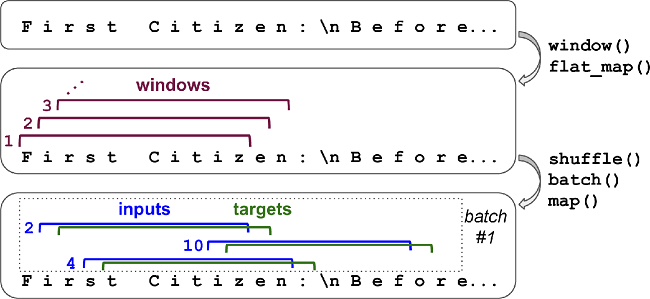
</p>
Figure 16-1. Preparing a dataset of shuffled windows

As discussed in Chapter 13, categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [72]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

Finally, we just need to add prefetching:

In [73]:
dataset = dataset.prefetch(1)

In [74]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Building and Training the Char-RNN Model

To **predict the next character based on the previous 100 characters,** we can use an **RNN with 2 GRU layers of 128 units** each and **20% dropout** on both the **inputs (dropout)** and the **hidden states (recurrent_dropout)**

The output layer is a time distributed Dense layer like we saw in Chapter 15. This time this **layer must have 39 units** (max_id) **because there are 39 distinct characters in the text,** and we want to **output a probability for each possible character** (at each time step)

The **output probabilities should sum up to 1** at each time step, so we apply the **softmax activation function** to the outputs of the Dense layer

We can then compile this model, using the **'sparse_categorical_crossentropy' loss and an Adam optimizer.** Finally, we are ready to train the model for several epochs

Finally, we are ready to train the model for several epochs (this may take many hours, depending on your hardware):

In [75]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
#history = model.fit(dataset, epochs=2) # 10 epochs originally, changed to 2 epochs for less training time since each epoch takes ~ 2 hours
#model.save('ch16_char_rnn.h5')

```
Epoch 1/2
31368/31368 [==============================] - 1632s 52ms/step - loss: 1.6199
Epoch 2/2
31368/31368 [==============================] - 1645s 52ms/step - loss: 1.5386
```



Trained and Uploaded Model on Github

In [76]:
from urllib import request
url = 'https://github.com/lucaslokchan/ml-journal/raw/master/Hands-On%20Machine%20Learning/Model/CH16_CHAR_RNN.h5'
request.urlretrieve(url, 'CH16_CHAR_RNN.h5')

('CH16_CHAR_RNN.h5', <http.client.HTTPMessage at 0x7f4ba3108790>)

In [77]:
model = keras.models.load_model('CH16_CHAR_RNN.h5')

## Using the Char-RNN Model

Now we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let’s create a little function for this:

In [78]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

Now let’s use the model to predict the next letter in some text:

In [79]:
# The predict_classes() method is deprecated. Instead, we must use np.argmax(model(X_new), axis=-1)
X_new = preprocess(['How are yo'])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

Success! The model guessed right. Now let’s use this model to generate new text

## Generating Fake Shakespearean Text

To generate new text using the Char-RNN model, we could **feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter,** and so on

But in practice this often **leads to the same words being repeated over and over again.** Instead, we can **pick the next character randomly,** with a **probability equal to the estimated probability,** using TensorFlow’s tf.random.categorical() function. This will generate **more diverse** and interesting text

The **categorical() function samples random class indices, given the class log probabilities (logits).** To have **more control over the diversity** of the generated text, we can **divide the logits by a number called the temperature,** which we can tweak as we wish: a **temperature close to 0 will favor the high-probability characters,** while a **very high temperature will give all characters an equal probability**

The following next_char() function uses this approach to pick the next character to add to the input text:

In [80]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

Next, we can write a small function that will **repeatedly call next_char()** to get the next character and append it to the given text:

In [81]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We are now ready to generate some text! Let's try with different temperatures:

In [82]:
print(complete_text('I',n_chars=150, temperature=0.2))

In the rest well well be to her father is a sight?

gremio:
i pray, sir, i will go the young and behalding to a world.

gremio:
i will contrive thee to


In [83]:
print(complete_text('Hello', n_chars=150, temperature=1))

Hellow! talk you is ill bo read the goess.
were we will till you plact: yea, as you have as so good hortensio:
but so i's your quarrelsiable clopelese in:



In [84]:
print(complete_text('Diu', n_chars=150, temperature=2))

Diust agno, meg biaimaunter;
knocking ook olyz;
mearuca; tell mos h rg, coees beg'e.
yoang had ye; pearheps, for weal wilm esttimolmves have help angyo,'


Apparently our Shakespeare model works best at a temperature close to 1 

To **generate more convincing text,** you could try using **more GRU layers** and more neurons per layer, **train for longer,** and add some **regularization** (for example, you could set recurrent_dropout=0.3 in the GRU layers)

Moreover, the model is currently incapable of learning patterns longer than n_steps, which is just 100 characters. You could try **making this window larger, but it will also make training harder,** and even **LSTM and GRU cells cannot handle very long sequences.** Alternatively, you could use a stateful RNN

## Stateful RNN

Until now, we have used only **stateless RNNs: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away,** as it is not needed anymore

What if we **told the RNN to preserve this final state after processing one training batch** and **use it as the initial state for the next training batch?** This way the **model can learn long-term patterns despite only backpropagating through short sequences.** This is called a stateful RNN. Let’s see how to build one

First, note that **a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off**

So the **first thing** we need to **do to build a stateful RNN** is to **use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences** we used to train stateless RNNs)

When creating the Dataset, we must therefore use shift=n_steps (instead of shift=1) when calling the window() method. Moreover, we must obviously not call the shuffle() method

Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. Indeed, **if we were to call batch(32),** then **32 consecutive windows would be put in the same batch, and the following batch would not contiune each of these window where it left off**

The **first batch would contain windows 1 to 32** and the **second batch would contain windows 33 to 64,** so if you consider, say, the **first window of each batch** (i.e., windows 1 and 33), you can see that they are **not consecutive**

**The simplest solution to this problem is to just use "batches" containing a single window:**

In [85]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Figure 16-2 summarizes the first steps

<p align='center'>
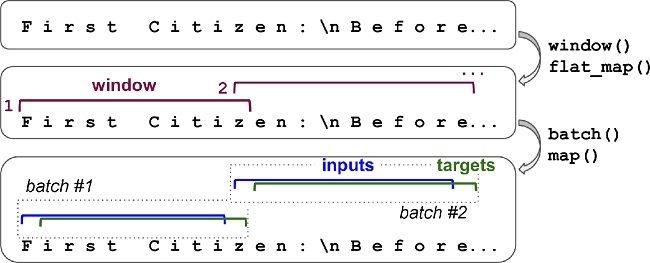
</p>
Figure 16-2. Preparing a dataset of consecutive sequence fragments for a stateful RNN

Batching is harder, but it is not impossible. For example, we could **chop Shakespeare’s text into 32 texts of equal length,** create one dataset of consecutive input sequences for each of them, and finally use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create proper consecutive batches, where the **$n^{th}$ input sequence** in a batch **starts off exactly where the $n^{th}$ input sequence ended in the previous batch**

In [86]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Now let’s create the stateful RNN. First, we need to set **statsful=True** when creating every recurrent layer. Second, the **stateful RNN needs to know the batch size** (since it will preserve a state for each input sequence in the batch), so we** must set the batch_input_shape argument in the first layer**

Note that we can leave the second dimension unspecified, since the inputs could have any length:

In [87]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation='softmax'))
])

At the **end of each epoch, we need to reset the states before we go back to the beginning of the text.** For this, we can use a small callback:

In [88]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

And now we can compile and fit the model (for more epochs, because each epoch is much shorter than earlier, and there is only one instance per batch):

In [89]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#history = model.fit(dataset, epochs=50,
#                    callbacks=[ResetStatesCallback()])

In [90]:
from urllib import request
url = 'https://github.com/lucaslokchan/ml-journal/raw/master/Hands-On%20Machine%20Learning/Model/CH16_CHAR_RNN_STATEFUL.h5'
request.urlretrieve(url, 'CH16_CHAR_RNN_STATEFUL.h5')

('CH16_CHAR_RNN_STATEFUL.h5', <http.client.HTTPMessage at 0x7f4ba3108290>)

In [91]:
model = keras.models.load_model('CH16_CHAR_RNN_STATEFUL.h5')

Now that we have built a character-level model, it’s time to look at **word level models** and tackle a common natural language processing task: **sentiment analysis**

# Sentiment Analysis

If MNIST is the “hello world” of computer vision, then the **IMDb reviews dataset is the “hello world” of natural language processing:** it consists of 50,000 movie reviews in English (25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review **indicating whether it is negative (0) or positive (1)**

Keras provides a simple function to load it

In [92]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [93]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

The dataset is already preprocessed for you: X_train consists of a list of reviews, each of which is represented as a NumPy array of integers, where **each integer represents a word**

**All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency** (so low integers correspond to frequent words)

The integers **0, 1, and 2** are special: they represent the **padding token, the start-of-sequence (SSS) token, and unknown words,** respectively. If you want to visualize a review, you can decode it like this:

In [94]:
word_index = keras.datasets.imdb.get_word_index()

In [95]:
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(('<pad>', '<sos>', '<unk>')):
  id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In a real project, you will have to preprocess the text yourself. You can do that using the same Tokenizer class we used earlier, but this time setting char_level=False (which is the default)

**When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs** (but you can change this by setting the filter argument)

Most importantly, it uses **spaces to identify word boundaries.** This is OK for English and many other scripts (written languages) that use spaces between words, but not all scripts use spaces this way

Chinese does not use spaces between words, Vietnamese uses spaces even within words, and languages such as German often attach multiple words together, without spaces. Even in English, spaces are not always the best way to tokenize text: think of “San Francisco” or “#ILoveDeepLearning.”

Fortunately, there are better options! The [2018 paper](https://arxiv.org/abs/1804.10959) by Taku Kudo introduced an unsupervised learning technique to **tokenize and detokenize text at the subword level in a language-independent way,** treating spaces like other characters

With this approach, **even if your model encounters a word it has never seen before, it can still reasonably guess what it means.** For example, it may never have seen the word “smartest” during training, but perhaps it learned the word “smart” and it also learned that the suffix “est” means “the most,” so it can infer the meaning of “smartest.”

Google's [SentencePiece](https://github.com/google/sentencepiece) project provides an open source implementation, described in a [paper](https://arxiv.org/abs/1808.06226) by Taku Kudo and John Richardson

Another option was proposed in an earlier [paper](https://arxiv.org/abs/1508.07909) by Rico Sennrich et al. that explored other ways of creating **subword encodings (e.g., using byte pair encoding).** Last but not least, the TensorFlow team released the [TF.Text](https://medium.com/tensorflow/introducing-tf-text-438c8552bd5e) library in June 2019, which implements various tokenization strategies, including [WordPiece](https://arxiv.org/abs/1609.08144) (a variant of byte pair encoding)

If you want to deploy your model to a mobile device or a web browser, and you don’t want to have to write a different preprocessing function every time, then you will want to handle preprocessing using only TensorFlow operations, so it can be included in the model itself

Let’s see how. First, let’s load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets

In [96]:
import tensorflow_datasets as tfds

datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_size = info.splits['train'].num_examples

In [97]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [98]:
for X_batch, y_batch in datasets['train'].batch(2).take(2):
  for review, label in zip(X_batch.numpy(), y_batch.numpy()):
    print('Review:', review.decode('utf-8')[:200], '...')
    print('label:', label, '= Positive' if label else '= Negative')
    print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
label: 0 = Negative

Review: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
label: 0 = Negative

Review: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
label: 1 = Positive



Next, let’s write the preprocessing function:

In [99]:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, 0, 300)
  X_batch = tf.strings.regex_replace(X_batch, b'br\\s*/?', b' ')
  X_batch = tf.strings.regex_replace(X_batch, b'^a-zA-Z', b' ')
  X_batch = tf.strings.split(X_batch)
  return X_batch.to_tensor(default_value=b'<pad>'), y_batch

It starts by **truncating** the reviews, **keeping only the first 300 characters** of each: this will speed up training, and it won’t impact performance too much because you can generally tell whether a review is positive or not in the first sentence or two

Then it uses regular expressions to **replace `<br/>` tags with spaces,** and to **replace any characters other than letters and quotes with spaces**

For example ```Well, I can't<br/>``` will become ```Well I can't```

Finally, the preprocess() function **splits the reviews by the spaces,** which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all reviews with the **padding token '<pad>'** so that they all have the **same length**

Next, we need to **construct the vocabulary.** This requires **going through the whole training set once,** applying our preprocess() function, and **using a Counter to count the number of occurrences of each word:**

In [100]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets['train'].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

Let’s look at the three most common words:

In [101]:
vocabulary.most_common()[:5]

[(b'<pad>', 224555),
 (b'the', 60433),
 (b'a', 38317),
 (b'of', 33744),
 (b'and', 32574)]

Great! We probably don’t need our model to know all the words in the dictionary to get good performance, though, so let’s **truncate** the vocabulary, **keeping only the 10,000 most common words:**

In [102]:
vocab_size = 10000
truncated_vocabulary = [
  word for word, count in vocabulary.most_common()[:vocab_size]]

Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary). Just like we did in Chapter 13, we will **create a lookup table** for this, **using 1,000 out-of-vocabulary (oov) buckets:**

In [103]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

We can then use this table to look up the IDs of a few words:

In [104]:
table.lookup(tf.constant([b'This movie was faaaaaantastic'.split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   23,    13,    10, 10053]])>

Note that the words **“this,” “movie,” and “was” were found in the table,** so their **IDs are lower than 10,000,** while the word **“faaaaaantastic” was not found,** so it was **mapped to one of the oov buckets,** with an **ID greater than or equal to 10,000**

In [105]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

train_set = datasets['train'].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [106]:
for X_batch, y_batch in train_set.take(1):
  print(X_batch)
  print(y_batch)

tf.Tensor(
[[   23    10    29 ...     0     0     0]
 [    6    22    62 ...     0     0     0]
 [ 5240  8414     1 ...     0     0     0]
 ...
 [   23    13   110 ...    11   293  2516]
 [ 1882  5478  4436 ...     0     0     0]
 [10727  4084 10963 ...     0     0     0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


At last we can create the model and train it:

In [107]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 46s 46ms/step - loss: 0.5748 - accuracy: 0.6859
Epoch 2/5
782/782 [==============================] - 37s 47ms/step - loss: 0.3672 - accuracy: 0.8446
Epoch 3/5
782/782 [==============================] - 37s 47ms/step - loss: 0.1903 - accuracy: 0.9321
Epoch 4/5
782/782 [==============================] - 37s 47ms/step - loss: 0.1298 - accuracy: 0.9529
Epoch 5/5
782/782 [==============================] - 36s 47ms/step - loss: 0.1045 - accuracy: 0.9615


The first layer is an **Embedding layer,** which will convert word IDs into embeddings

**The embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets) and one column per embedding dimension** (this example uses 128 dimensions, but this is a hyperparameter you could tune)

Whereas the **inputs** of the model will be **2D tensors of shape [batch size, time steps],** the **output** of the Embedding layer will be a **3D tensor of shape [batch size, time steps, embedding size]**

The rest of the model is fairly straightforward: it is composed of two GRU layers, with the second one returning only the output of the last time step. The output layer is just a **single neuron** using the **sigmoid activation function** to **output the estimated probability that the review expresses a positive sentiment** regarding the movie. We then compile the model quite simply, and we fit it on the dataset we prepared earlier, for a few epochs.

## Masking

The model will need to learn that the padding tokens should be ignored. simply add **mask_zero=True** when creating the Embedding layer, this means that padding tokens (whose ID is 0) will be ignored by all downstream layers

The way this works is that the **Embedding layer creates a mask tensor** equal to K.not_equal(inputs, 0) (where K = keras.backend): it is a **Boolean tensor with the same shape as the inputs,** and it is equal to **False anywhere the word IDs are 0,** or **otherwise True**

This mask tensor is then automatically propagated by the model to all subsequent layers, as long as the time dimension is preserved

So in this example, both GRU layers will receive this mask automatically, but since the second GRU layer does not return sequences (it only returns the output of the last time step), the mask will not be transmitted to the Dense layer. Each layer may handle the mask differently, but in general they simply **ignore masked time steps (i.e., time steps for which the mask is False)**

For example, **when a recurrent layer encounters a masked time step,** it simply **copies the output from the previous time step.** If the mask propagates all the way to the output (in models that output sequences), then it will be applied to the losses as well, so the masked time steps will not contribute to the loss (their loss will be 0)



**All layers that receive the mask must support masking **(or else an exception will be raised). This includes **all recurrent layers,** as well as the **TimeDistributed layer** and a few other layers. **Any layer that supports masking must have a supports_masking attribute equal to True**

If you want to **implement** your own **custom layer with masking support,** you should **add a mask argument to the call() method** (and obviously make the method use the mask somehow). Additionally, you should **set self.supports_masking = True in the constructor**

If your layer **does not start with an Embedding layer,** you may **use the keras.layers.Masking** layer instead: it sets the mask to K.any(K.not_equal(inputs, 0), axis=-1), meaning that time steps where the last dimension is full of zeros will be masked out in subsequent layers (as long as the time dimension exists)

Using **masking layers and automatic mask propagation** works best for simple Sequential models, It **will not always work for more complex models,** such as when you need to mix Conv1D layers with recurrent layers

In such cases, you will need to explicitly compute the mask and pass it to the appropriate layers, using either the Functional API or the Subclassing API

For example, the following model is **identical to the previous model,** except it is built using the Functional API and handles masking manually:

In [ ]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 46s 47ms/step - loss: 0.5818 - accuracy: 0.6784
Epoch 2/5
782/782 [==============================] - 37s 47ms/step - loss: 0.3838 - accuracy: 0.8342
Epoch 3/5
782/782 [==============================] - 37s 47ms/step - loss: 0.2088 - accuracy: 0.9229
Epoch 4/5
782/782 [==============================] - 36s 47ms/step - loss: 0.1528 - accuracy: 0.9438
Epoch 5/5
676/782 [========================>.....] - ETA: 4s - loss: 0.1223 - accuracy: 0.9546

After training for a few epochs, this model will become quite good at judging whether a review is positive or not

If you use the TensorBoard() callback, you can visualize the embeddings in TensorBoard as they are being learned: it is fascinating to see words like “awesome” and "amazing" gradually cluster on one side of the embedding space, while words like “awful” and “terrible” cluster on the other side

Some words are not as positive as you might expect (at least with this model), such as the word “good,” presumably because many negative reviews contain the phrase “not good.”

We can reuse word embeddings trained on some other large text corpus (e.g., Wikipedia articles)

## Reusing Pretrained Embeddings

The [TensorFlow Hub](https://tfhub.dev/) project makes it easy to reuse pretrained model components in your own models. These model components are called modules

Simply browse the TF Hub repository, find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model

For example, let’s use the **nnlm-en-dim50 sentence embedding module,**
version 1, in our sentiment analysis model:

In [ ]:
import os
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') 
])
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

The **hub.KerasLayer layer downloads the module** from the given URL

This particular module is a **sentence encoder:** it takes strings as input and **encodes** each one as a **single vector** (in this case, a 50-dimensional vector)

Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (**seven billion words** long!). Then it **computes the mean of all the word embeddings,** and the result is the **sentence embedding**

We can then add two simple Dense layers to create a good sentiment analysis model. **By default, a hub.KerasLayer is not trainable,** but you can set **trainable=True** when creating it to change that so that you can fine-tune it for your task

Next, we can just load the IMDb reviews dataset—no need to preprocess it (except for batching and prefetching)—and directly train the model:

In [ ]:
datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_size = info.splits['train'].num_examples
batch_size = 32
train_set = datasets['train'].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Note that the last part of the TF Hub module URL specified that we wanted version 1 of the model. This versioning ensures that if a new model version is released, it will not break our model. Conveniently, if you just enter this URL in a web browser, you will get the documentation for this module

**By default, TF Hub will cache the downloaded files into the local system’s temporary directory.** You may prefer to download them into a more permanent directory to avoid having to download them again after every system cleanup

To do that, set the TFHUB_CACHE_DIR environment variable to the directory of your choice (e.g., **os.environ["TFHUB_CACHE_DIR"] = "./my_tfhub_cache")**

So far, we have looked at time series, text generation using Char-RNN, and sentiment analysis using word-level RNN models, training our own word embeddings or reusing pretrained embeddings

Let’s now look at another important NLP task: **neural machine translation (NMT),** first using a pure **Encoder–Decoder model,** then improving it with **attention mechanisms,** and finally looking the extraordinary **Transformer architecture**

# An Encoder–Decoder Network for Neural Machine Translation

Let's take a look at a simple [neural machine translation model](https://arxiv.org/abs/1409.3215) that will translate English sentences to French (see Figure 16-3)

In short, the **English sentences are fed to the encoder,** and the **decoder outputs the French translations.** Note that the **French translations are also used as inputs to the decoder, but shifted back by one step**

In other words, the decoder is given as input the word that it should have output at the previous step (regardless of what it actually output)

For the very **first word,** it is given the **start-of-sequence (SOS) token.** The **decoder** is expected to **end the sentence with an end-of-sequence (EOS) token**

Note that the **English sentences are reversed before they are fed to the encoder.** For example, “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate

Each word is initially represented by its ID (e.g., 288 for the word “milk”) Next, an layer returns the word embedding. These word embedding embeddings are what is actually fed to the encoder and the decoder

<p align='center'>
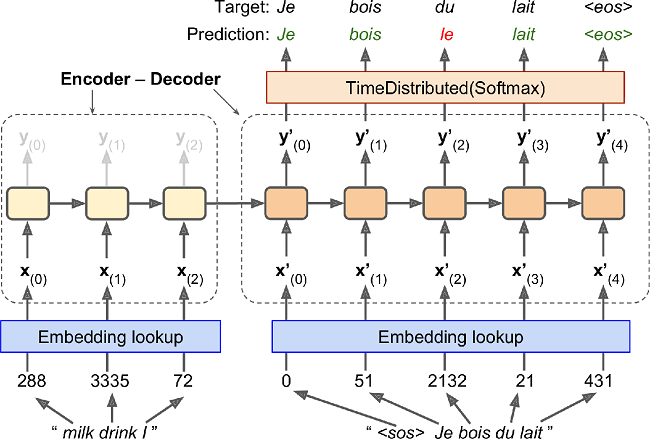
</p>
Figure 16-3. A simple machine translation model

At each step, the **decoder outputs a score for each word in the output vocabulary** (i.e., French), and then the **softmax layer** turns these scores into **probabilities.** For example, at the first step the word “Je” may have a probability of 20%, “Tu” may have a probability of 1%, and so on. The word with the highest probability is output. **This is very much like a regular classification task,** so you can train the model using the "sparse_categorical_crossentropy" loss

Note that **at inference time** (after training), you will not have the target sentence to feed to the decoder. Instead, **simply feed the decoder the word that it output at the previous step,** as shown in Figure 16-4 (this will require an embedding lookup that is not shown in the diagram)

<p align='center'>
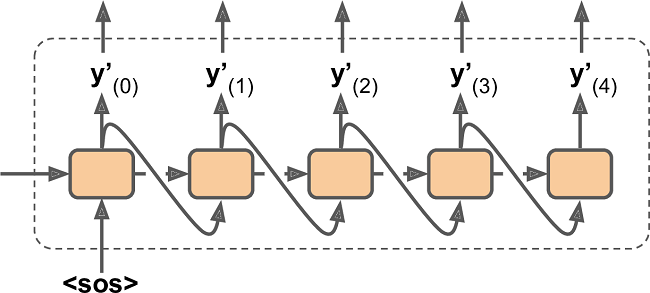
</p>
Figure 16-4. Feeding the previous output word as input at inference time

There are a few more details to handle if you implement this model:

